### Description
When 
    the opening minute price dips x standard deviations below the short EMA   (maybe not)
    
    and the short current RSI is y standard deviations below its average   
    
    and the long current RSI is z standard deviations below its average  
    
        Buy 1 stock
When 
    the opening minute price goes x standard deviations above the short EMA  (maybe not)
    
    and the short current RSI is y standard deviations above its average  
    
    and the long current RSI is z standard deviations above its average 
    
        sell 1 stock
        
graphing
    1
    close price
    state the current RSI number
    bands for the buy/sell mark
    
    2
    RSI short
    state the current RSI number
    bands for the buy/sell mark
    
    3
    RSI long
    state the current RSI number
    bands for the buy/sell mark
    
    
Advice print out
    percentile, rsi 1 month high, rsi 1 week high, 1 day, what percentile of deviation away from a given sma
    
    Notes:
    back trading
    https://alpaca.markets/learn/backtrader-01/
    alpaca example code
    https://alpaca.markets/docs/api-documentation/how-to/
    https://alpaca.markets/docs/api-documentation/api-v2/market-data/alpaca-data-api-v2/real-time/

### IMPORTING

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize      import fsolve, curve_fit
from scipy.integrate     import odeint, quad
from scipy.interpolate   import interp1d
from scipy.misc          import derivative
import scipy.constants   as const
import sympy             as sp
sp.init_printing()
import glob
import time
import math
import alpaca_trade_api as tradeapi
from alpaca_trade_api import StreamConn
import threading
import time
import datetime
import logging
import argparse
import time
import pandas as pd
ALPACA_BASE_URL ='https://paper-api.alpaca.markets';
KEY = 'PK6Q22HTB5JPL4O35ZHM'
SCRKEY = 'sqv5r84hE7j1rqDVtUH5yC9qUEhJoND07DvuK3mG'

from lxml import html
import requests
import json
import argparse
from collections import OrderedDict

import talib as tlb
import scipy.stats as stat

### CLASS DATA

In [12]:
class I():
    def __init__ (self,symbol,x=1,y=1,z=1,rsi_s=14, rsi_l=200,ema_s=14, ema_l=20):
        self.symbol = symbol
        self.rsi_s  = rsi_s
        self.rsi_l  = rsi_l
        self.x      = x
        self.y      = y
        self.z      = z
        self.ema_s  = ema_s
        self.ema_l  = ema_l
        self.api    = tradeapi.REST(KEY, SCRKEY, ALPACA_BASE_URL, api_version='v2')
        self.sb     = self.api.get_barset(self.symbol, 'minute', limit = 100).df   
        #self.prices = self.sb[self.symbol]['close']
        
    def close(self):
        c = self.sb[self.symbol]['close']
        return c[-1]  #returns most recent data point
    
    def EMA_s(self):
        Data = self.api.get_barset(self.symbol, 'minute', limit=self.ema_s).df
        SEMA = Data[self.symbol]['close'].rolling(window=self.ema_s).mean()
        ema_last = SEMA[-1]
        return ema_last
    
    def EMA_l(self):
        #api = self.api()
        Data = self.api.get_barset(self.symbol, '15Min', limit=self.ema_l).df
        lEMA = Data[self.symbol]['close'].rolling(window=self.ema_l).mean()
        ema_last = lEMA[-1]
        return ema_last
    
    def RSI_l(self): #what is the current RSI value for the longer period
        RSI = tlb.RSI(self.prices, timeperiod=self.rsi_s)
        return RSI[-1]
    
    def RSI_s(self):
        RSI = tlb.RSI(self.prices, timeperiod=self.rsi_s)
        return RSI[-1]  #returns last 
    
    def RSI_per(self, interval='day'):
        if interval== 'day':
            length=78
            period='5Min'
            TimePeriod=14
            
        if interval=='week':
            length=130
            period='15Min'
            TimePeriod=14
            
        if interval=='month':
            length=1000
            period='15Min'
            TimePeriod=56
            
        self.api    = tradeapi.REST(KEY, SCRKEY, ALPACA_BASE_URL, api_version='v2')
        sb     = self.api.get_barset(self.symbol, period, limit = length).df  
        prices = self.sb[self.symbol]['close']
        RSI = tlb.RSI(prices, timeperiod=TimePeriod)
        B = stat.scoreatpercentile(RSI[TimePeriod:], [1,5,10,25,50,75,90,95,99]) #99% means rsi_current is above 99%
        return B #B #{one:,five:,ten:,twentyfive:, fifty:, seventyfive:,ninety:, ninetyfive:,ninetynine: }
    
    
    #function that tells me where the current RSI lies within the percentile spectrum. 1 func for any given interval
    def RSI_per_place(self, interval='day'):
        
        if interval== 'day':
            length=60
            period='5Min'
            TimePeriod=14
            
        if interval=='week':
            length=130
            period='15Min'
            TimePeriod=14
            
        if interval=='month':
            length=1000
            period='15Min'
            TimePeriod=56
        RSI_array = self.RSI_per(interval=interval)
        A = [1,5,10,25,50,75,90,95,99]
        self.api    = tradeapi.REST(KEY, SCRKEY, ALPACA_BASE_URL, api_version='v2')
        sb     = self.api.get_barset(self.symbol, period, limit = length).df  
        prices = self.sb[self.symbol]['close']
        RSI = tlb.RSI(prices, timeperiod=TimePeriod)        
        RSI_current = RSI[-1]      
        RSI_place = []
        
        for count,i in enumerate(RSI_array,1):
            if RSI_current<i:                
                RSI_place.append(A[count])
                break
        return RSI_place[0]
    
    
    def plot(self,interval='day'):       
        if interval== 'day':
            length=78
            period='5Min'
            TimePeriod=14
            
        if interval=='week':
            length=130
            period='15Min'
            TimePeriod=14
            
        if interval=='month':
            length=1000
            period='15Min'
            TimePeriod=56
        
        timeperiod= self.rsi_s           
        self.sb     = self.api.get_barset(self.symbol, period, limit = length).df   
        self.prices = self.sb[self.symbol]['close']
        RSI_day = tlb.RSI(self.prices, timeperiod=timeperiod)[timeperiod:]
        t = np.linspace(0,len(RSI_day),len(RSI_day))
        plt.plot(t,RSI_day)
        #plotting the levels
        levels = self.RSI_per(interval=interval)
        name_level = [1,5,10,25,50,75,90,95,99]
        for i, N in enumerate(levels,0):
            plt.plot(t,N*np.ones(length-14), label=f'{name_level[i]} % level')
        #plt.legend();
        print(f'The RSI percentile for the {interval} length is {self.RSI_per_place()} %')
        return RSI_day
    
    def analysis_plot(self):
        plt.figure(figsize=(20,20))
        plt.subplot(3,1,1)
        plt.title('Day', fontsize=20)
        self.plot(interval='day')
        
        plt.subplot(3,1,2)
        plt.title('Week', fontsize=20)
        self.plot(interval='week')
        
        plt.subplot(3,1,3)
        plt.title('Month', fontsize=20)
        self.plot(interval='month')
        plt.xticks(fontsize=20)
        return 
        
        
        
    def ema_sdev(self):
        return 1
    
    def RSI_sdev_s(self):
        return 1
    
    def RSI_sdev_l(self):
        return 1

The RSI percentile for the day length is 75 %
The RSI percentile for the week length is 50 %
The RSI percentile for the month length is 10 %


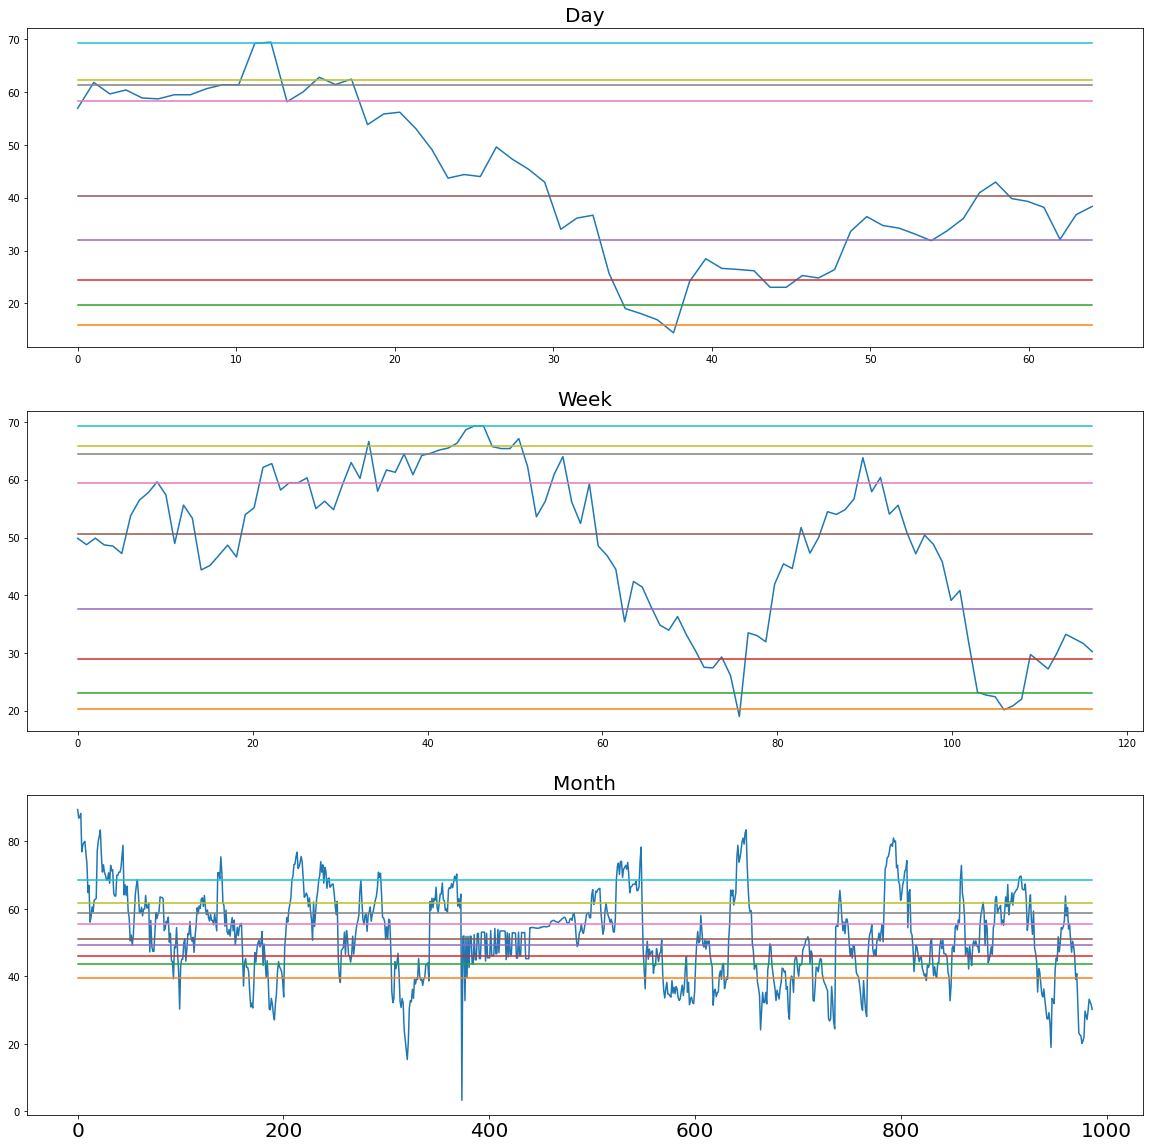

In [13]:
#month is really biweekly (use alpha vantage to get longer arrays)
RSI_percentile = I('SCHN').analysis_plot()

### STOCK BOT

In [ ]:
#WHEN WE CALL THIS BOT FUNCTION IT WILL BUY IF THE RSI INDICATES THAT THE PRICE WILL GO UP AND WILL SELL
#IF THE RSI INDICATES THAT THE PRICE WILL GO DOWN.  
def bot(symbol):
    lengths = ['day','week','month']
    levels = {}
    for l in lengths:
        levels[l]=I(symbol).RSI_per_place(interval=l)
        
    if levels['month']<=50 and levels['week']<=50 and levels['day']<=20:
        api.submit_order(symbol, 1, 'buy', 'market', 'day')
        print(f'bought one share of {symbol}')
    
    if levels['month']>=70 and levels['week']>=80 or levels['day']>70:
        api.submit_order(symbol, 1, 'sell', 'market', 'day')
        print(f'sold one share of {symbol}')

### CALLING THE BOT

In [ ]:
#CALLING THE BOT THAT WILL BUY IF THE RSI INDICATES THE PRICE WILL GO UP

while True:
    TIME = time.localtime()
    minute = TIME.tm_min
    hr = TIME.tm_hour   
    if hr>7 and minute>28:
        t = 1
    if 13>hr>8:
        t = 1
    if hr==13 and minute<40:
        t = 1
    else:
        t = 0  
    if t==1:
        bot('TSLA')
        time.sleep(5)
    if t!=1:
        time.sleep(1800)
    

### APP interface

In [129]:
from kivy.interactive import InteractiveLauncher
from kivy.app import App
from kivy.uix.button import Button
from kivy.core.window import Window
from kivy.uix.gridlayout import GridLayout

from kivy.uix.label import Label
from kivy.uix.textinput import TextInput
from kivy.uix.boxlayout import BoxLayout


In [ ]:
#CLASS APPLICATION
class app(App):
    def build(self):
        self.title = "Stock Analysis (Write the Ticker in the box below)"
        Window.size=(400,200)
        layout = GridLayout(cols=2,rows=1,padding=10, spacing=10, row_default_height=30)
        symbol = TextInput()
        symbol_label = Label(text='symbol', size_hint_x=None, width=100)
        
        #ADDING WIDGETS
        layout.add_widget(symbol_label)
        layout.add_widget(symbol)
        
        #LAYOUT
        main_layout = BoxLayout(orientation='vertical', padding=10,spacing=10)
        calculate = Button(text='Calculate')
        main_layout.add_widget(calculate)
        
        return main_layout
    def action(self):
        I(self).analysis_plot()

if __name__ =='__main__':
    app = app()
    app.action()

In [105]:
from kivy.app import App
from kivy.uix.image import Image

class MainApp(App):
    def build(self):
        img = Image(source='/path/to/real_python.png',
                    size_hint=(1, .5),
                    pos_hint={'center_x':.5, 'center_y':.5})

        return img

if __name__ == '__main__':
    app = MainApp()
    app.run()